# Deep Convolutional GANs

En este notebook, vamos a construir un GAN usando convolutional layers en el generador y discriminador. Esto se conoce como un Deep Convolutional GAN, o DCGAN. La arquitectura del DCGAN fue explorada por primera vez en el 2016 y tuvo resultados impresionantes en generar nuevas imagenes; pueden leer el [paper original aqui](https://arxiv.org/pdf/1511.06434.pdf)

Van a entrenar el DCGAN en el dataset de [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/)(SVHN). Estas son imagenes a color de numeros de casa recolectados de Google street view. Las imagenes de SVHN son a color y tienen mucho mas variedad que MNIST.

Entonces, nuestra meta es crear un DCGAN que pueda generar nuevas imagenes que se vean realisticas de numeros de casas. Vamos a seguir los siguientes pasos para hacer esto:
* Cargar y pre-procesar el dataset
* Definir el discriminador y el generador
* Entrenar estos networks adversarios
* Visualizar el loss a traves del tiempo y una muestra de imagenes generadas

**Deeper Convolutional Networks**

Ya que este dataset es mas complejo que la data de MNIST, necesitamos una red mas profunda para identificar patrones en estas imagenes y poder generar nuevas. Especificamente, vamos a usar una serie de convolutional o transpose convolutional layers en el discriminador y generador. Tambien es necesario usar batch normalization para entrenar convolutional networks.

Aparte de estos cambios en la estructura de la red, entrenar el discriminador y el generador deberia ser igual que siempre. Es decir, el discriminador va a alternar su entrenamiento entre imagenes reales y falsas (generadas) y el generador va a intentar enganiar al discriminador para que crea que las imagenes generadas son reales.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

## Obtener la data

Aqui vamos a descargar el dataset SVHN. Es un dataset que trae PyTorch en su modulo de datasets. Podemos cargar la data de entrenamiento, transformarla a tensores, y crear dataloader para hacer batches del tamanio deseado.

In [6]:
import torch
from torchvision import datasets
from torchvision import transforms

# Tensor transform
transform = transforms.ToTensor()

# SVHN training datasets
svhn_train = datasets.SVHN(root='../data/SVHN/', split='train', download=True, transform=transform)

batch_size = 128
num_workers = 0

# build DataLoaders for SVHN dataset
train_loader = torch.utils.data.DataLoader(dataset=svhn_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers)



0it [00:00, ?it/s]



  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 16384/182040794 [00:00<21:00, 144392.92it/s]

 27%|██▋       | 49815552/182040794 [00:47<01:12, 1824389.23it/s]

  0%|          | 49152/182040794 [00:00<29:07, 104137.62it/s]

  0%|          | 73728/182040794 [00:01<27:59, 108323.18it/s]

  0%|          | 98304/182040794 [00:01<27:08, 111731.65it/s]

  0%|          | 122880/182040794 [00:01<26:35, 113984.19it/s]

  0%|          | 155648/182040794 [00:01<24:17, 124779.09it/s]

  0%|          | 188416/182040794 [00:01<22:40, 133645.82it/s]

  0%|          | 229376/182040794 [00:02<20:25, 148384.08it/s]

  0%|          | 262144/182040794 [00:02<19:59, 151599.80it/s]

  0%|          | 311296/182040794 [00:02<17:45, 170552.37it/s]

  0%|          | 360448/182040794 [00:02<14:33, 208007.99it/s]

  0%|          | 409600/182040794 [00:02<13:44, 220230.18it/s]

  0%|          | 466944/182040794 [00:03<12:52, 235157.10it/s]

  0%|          | 524288/182040794 [00:03<12:14, 247215.1

## Visualizar la data

Una pequenia muestra de las imagenes. Cada una es de 32x32 con 3 canales de color (RGB). Estas son las imagenes reales de entrenamiento que le vamos a pasar al discriminador. Noten que cada imagen tiene un _uno_ asociado como etiqueta numerica.

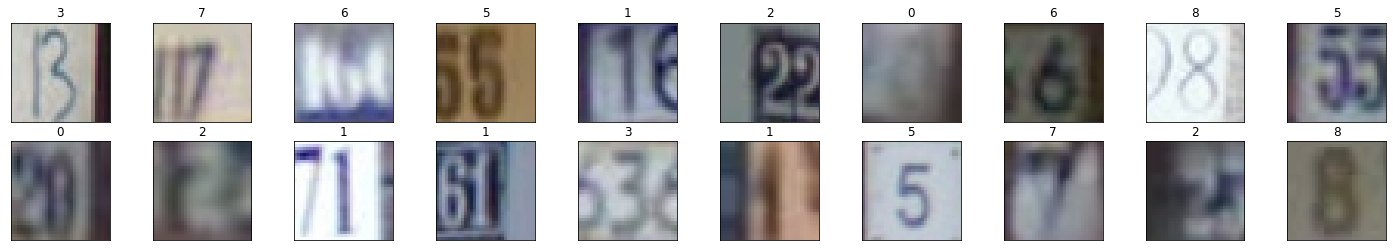

In [3]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(25, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(str(labels[idx].item()))

## Pre-procesar: escalar de -1 a 1

Sabemos que el output de nuestro generador activado por `tanh` va a contener pixeles con valores entre $[-1,1]$ y por tanto necesitamos re escalar nuestras imagenes de entrenamiento a un rango de $[-1,1]$. Ahorita se encuentran en un rango entre $[0,1]$

In [7]:
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.0549)
Max:  tensor(0.8196)


In [8]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min_val, max_val = feature_range
    x = x * (max_val - min_val) + min_val
    return x

In [9]:
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-0.8902)
Scaled max:  tensor(0.6392)


## Definir el Modelo

Un GAN esta compuesto por dos redes adversarias, un discriminador y un generador

### Discriminador

El discriminador es un clasificador como el que trabajamos en la clase anterior, solo que sin maxpooling layers.
* Los inputs son tensores de 32x32x3
* Vamos a usar un par de convolutional, hidden layers
* Al final una fully connected layer para el output; como antes, queremos un output sigmoide, pero vamos a agregar eso en el loss function

Para la profundidad de las convolutional layers sugiero empezar con 32 filters en la primer layer, luego doblar esa profundidad mientras vayan agregando mas layers (a 64, 128, etc.). Noten que en el paper de DCGAN, hicieron todo el downsampling usando unicamente strided convolutional layers sin maxpooling layers.

Tambien van a querer usar batch normalization con [nn.BatchNorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d) en cada layer **excepto** la primera convolutional layer y la ultima linear output layer.

**Helper function para los convolutions**

En general, cada layer deberia de verse algo asi:
    * convolution
    * batch norm
    * leaky ReLU

Por tanto, vamos a definir una funcion que pone todos estos layers juntos. Esta funcion va a crear un secuencia de convolutional + una layer opcional de batch norm. Vamos a crear esto usando los [containers secuenciales](https://pytorch.org/docs/stable/nn.html#sequential) de PyTorch, que toman una lista de layers y crea layers de acuerdo al orden en el que son pasados al constructor.

Nota: tambien sugiero que usen **kernel_size de 4** y un **stride de 2** para los strided convolutions.

In [10]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # usando el Sequential container
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out)        
        return out

## Generador

El generador toma como input un vector de ruido z y el output va a ser un $tanh$ output, pero esta vez con tamanio 32x32 que es el tamanio de las imagenes SVHN.

Lo que es nuevo aqui es que vamos a usar transpose convolutional layers para crear nuestras imagenes.
* El primer layer es un fully connected layer que es reshaped a una layer profunda y estrecha, algo como 4x4x512
* Luego, usamos batch normalization y una activacion leaky ReLU
* Luego es una series de [transpose convolutional layers](https://pytorch.org/docs/stable/nn.html#convtranspose2d), donde normalmente tenemos la mitad de profundidad y el doble de width y height del layer anterior.
* Y, vamos a aplicar batch normalization y ReLU a todas excepto la ultima de estas hidden layers. En donde solo vamos a aplicar una activacion tanh.

**Helper deconv function**

Para cada una de estas layers, el esquema general es:
    * transpose convolution
    * batch norm
    * ReLU
    
Por tanto, vamos a definir una funcion para poner todos estos layers juntos. Esta funcion va a crear una secuencia de transpose convolutional + un layer opcional de batch norm. 

Nota: De nuevo sugiero usar **kernel_size de 4** y un **stride de 2** para los transpose convolutions.

In [12]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = F.tanh(out)
        
        return out

## Crear la red completa

Definir los hiperparametros del model e instanciar el discriminador y generador de las clases que definimos arriba.

In [14]:
# define hyperparams
conv_dim = 32
z_size = 100

# define discriminator and generator
D = Discriminator(conv_dim)
G = Generator(z_size=z_size, conv_dim=conv_dim)

print(D)
print()
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Entrenar en GPU

Revisar si podemos usar un GPU. Si es posible, establecerlo como una variable y mover los modelos al GPU.

> Luego, tambien vamos a mover cualquier input a los modelos y loss functions (ver real_images, z, y labels) al GPU.

In [15]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    # move models to GPU
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')

GPU available for training. Models moved to GPU


## Losses del Discriminador y Generador

Ahora necesitamos calcular el loss.

### Discriminator Losses

> * Para el discriminador, el loss total es la suma de los losses para las imagenes reales y falsas, `d_loss = d_real_loss + d_fake_loss`.
> * Recuerden que queremos que el discriminador genere un ouput cercano a 1 para imagenes reales y 0 para falasas. asi que necesitamos que los losses reflejen eso.

Los losses van a ser binary cross entropy loss with logits, que podemos obtener con [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss). Esto comina una activacion `sigmoid` **y** el binary cross entropy loss en una sola funcion.

Para las imagenes reales, queremos que `D(real_images) = 1`. Es decir, queremos que el discriminador clasifique las imagenes reals con un label = 1, indicando que son reales. El los del discriminador para la data falsa es similar. Queremos que `D(fake_images) = 0`, donde las imagenes falsas son el output del generador, `fake_images = G(z)`.

## Generator Loss

El loss del generador se va a ver similar pero con los labels al reves. La meta del generador es que `D(fake_images) = 1`. En este caso, los labels estan **al reves** para representar que el generador esta tratando de enganiar al discriminador.

In [16]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss


def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

Nada nuevo aqui. Solo noten que estoy usando un learning rate pequenio y parameters custom para el Adam optimizer. Esto es basado en research sobre la convergencia del DCGAN.

### Hiperparametros

Los GANs son sumamente sensibles a los hiperparametros. Un monton de experimentacion es necesaria para encontrar los mejores hiperparametros para que el generador y el discriminador no se ganen. Intenten con sus propios hiperparametros o lean [el DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) para ver que les funciono a ellos.

In [17]:
import torch.optim as optim

# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

## Entrenamiento

El entrenamiento va a necesitar alternar entre entrenar el discriminador y el generador. Vamos a usar nuestras funciones `real_loss` y `fake_loss` para calcular el loss del discriminador en todos los casos que siguen.

### Discriminator training

1. Calcular el loss del discriminador para imagenes reales, del training set
2. Generar imagenes falsas
3. Calcular el loss del discriminador en imagenes falsas, generadas.
4. Sumar el real y fake loss
5. Realizar backprop + un paso del optimizador para actualizar los pesos del discriminador

### Generator trainig

1. Generar imagenes falsas
2. Calcular el loss del discriminador en imagenes falsas, usando los labels **al reves**
3. Realizar backprop + un paso del optimizador para actualizar los pesos del generador

**Modo de evaluacion**

Noten que, cuando llamamos al generador para crear las muestras para display, configuramos al modelo en modo evaluacion: `G.eval()`. Esto es para que los layers de batch normalization usen las estadisticas de la poblacion en vez de las estadisticas del batch (como lo hacen durante el entrenamiento), y los dropout layers van a operar en modo `eval()`; sin apagar nodos para generar muestras.

In [ ]:
import pickle as pkl

# training hyperparams
num_epochs = 50

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 300

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        # important rescaling step
        real_images = scale(real_images)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        if train_on_gpu:
            real_images = real_images.cuda()
        
        D_real = D(real_images)
        d_real_loss = real_loss(D_real)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        # move x to GPU, if available
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images            
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to training mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

## Training loss

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Muestras del generador de entrenamiento

In [18]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [ ]:
_ = view_samples(-1, samples)